In [1]:
%run __init__.py
%load_ext autoreload
%autoreload 2

In [2]:
import cv2 as cv
import numpy as np
from utils.io_utils import get_images, draw_detections
from utils.calib_utils import detect_keypoints

In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/konstantin/.local/lib/python3.6/site-packages/m

In [3]:
pattern_size = (8, 6)
edge_length = 0.055
data_path = "/home/konstantin/datasets/bandeja-sequence/2021_02_17/2021-02-17-16-07-15_chessboard_plane/smartphone_video_frames"

In [4]:
images = get_images(data_path, start=380, period=8)

In [5]:
len(images)

178

In [6]:
results = detect_keypoints(images, pattern_size, edge_length=edge_length)

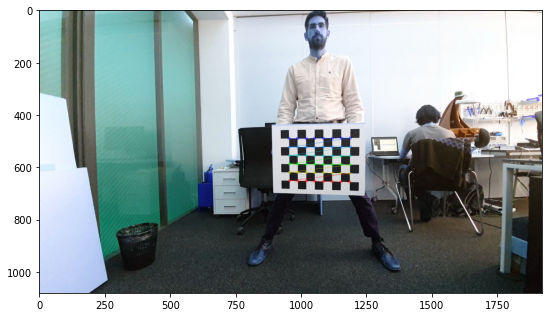

In [7]:
draw_detections(images, results, pattern_size, 1, normalize=True)

In [8]:
calib_intrinsincs = np.load('../calib_output/s10_intrinsics.npy', allow_pickle=True).item()


In [9]:
intrinsics = calib_intrinsincs['intrinsics']
dist_coeff = calib_intrinsincs['dist_coeff']
undist_intrinsics = calib_intrinsincs['undist_intrinsics']

In [10]:
output = {}
num_points = pattern_size[0] * pattern_size[1]

for key, (scene_points, loc_kp) in results.items():
    success, r, t = cv.solvePnP(scene_points, loc_kp, intrinsics, dist_coeff, flags=cv.SOLVEPNP_IPPE)

    if success:
        T = np.zeros((4, 4))
        T[:3, :3] = cv.Rodrigues(r)[0]
        T[:3, 3] = np.reshape(t, -1)
        T[3, 3] = 1
        
        scene_points_h = np.concatenate((scene_points, np.ones((num_points, 1))), axis=-1)
        t_scene_points = (T @ scene_points_h.transpose()).transpose()[:, :3]
        
        output[key.split('.')[0]] = (T, t_scene_points)


In [11]:
np.save('../calib_output/pnp_results', output)

In [16]:
# loc_kp_scene_points = []

# for loc_kp, chess2cam_T_i in zip(loc_kp0, chessboard2camera_T):
#     loc_kp_h = np.concatenate((np.reshape(loc_kp, (num_points, 2)), np.ones((num_points, 1))), axis=-1)
    
#     n_loc_kp = (np.linalg.inv(undist_intrinsics0) @ loc_kp_h.transpose()).transpose()
    
#     n_loc_kp_h = np.concatenate((n_loc_kp, np.ones((num_points, 1))), axis=-1)
    
#     # Uncomment to see only rotational part
# #     chess2cam_T_i[:3, 3] = 0
    
#     chessboard_loc_kp = (np.linalg.inv(chess2cam_T_i) @ n_loc_kp_h.transpose()).transpose()[:, :3]
    
#     loc_kp_scene_points.append(chessboard_loc_kp)
    

In [17]:
# np.save('loc_kp_scene_points', loc_kp_scene_points)